## 进阶作业：共享单车用户数预测

### 作业要求:
利用美国某共享单车公司2011/2012年数据，训练和测试一个模型，并对模型的性能和预测能力进行测试。

### 批改标准
3. 对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，评价指标为RMSE。（10分） 
4. 用训练数据训练最小二乘线性回归模型（20分）、岭回归模型、Lasso模型，其中岭回归模型（30分）和Lasso模型（30分），注意岭回归模型和Lasso模型的正则超参数调优。 
5. 比较用上述三种模型得到的各特征的系数，以及各模型在测试集上的性能。并简单说明原因.

### 实现思路
特征工程：

1. 数据探索

 使用pandas查看数据规模、特征维数、特征涵义、特征数据类型；
 查看特征描述统计量、空值数量；
 用直方图、箱体图、提琴图等查看单变量大致分布、是否有噪声数据；
 用相关矩阵热力图、scatter/hue查看两特征之间相关性；

2. 数据预处理
    
    删除冗余、噪音数据；
    处理缺失值；
    数据分离；
    离散型特征编码；
    数值特征标准化；
    
3. 确定模型类型
  
4. 评价性能

## 1.导入必要工具包

In [66]:
import numpy as np #矩阵处理
import pandas as pd #数据处理

from sklearn.metrics import r2_score # 评价回归预测模型的性能

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt #画图
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder # 数据标准化

from scipy.sparse import hstack

# 图形出现在Notebook里而不是新窗口
%matplotlib inline


## 2.数据探索
见文件　CBdata.ipynb

### 2.1 读取数据

In [68]:
# dapath = '/media/wyb/work/AI-learning/ai/week-00/ML-Capital-Bikeshare/dataset/'  # 数据文件路径

cb = pd.read_csv('../dataset/day.csv')  # 以csv格式读取数据

# print "cb　data type is %s" % cb.dtypes  # 输出各字段数据类型

cb.head()  # 打印文件头部内容，查看各字段前五列数据值
# print cb.tail()  # 打印数据尾部五个数据值


# 读取样本数目、特征维数每个特征的类型、空值样本数目、数据类型
cb.shape



(731, 16)

## 2.2 数据准备

In [69]:
y = cb['cnt']

X = cb.drop(['dteday','instant','casual','registered','cnt'],axis=1)

# 训练数据与测试数据8/2分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [70]:
# 使用RMSE评价
from sklearn.metrics import mean_squared_error

rmse_on_test = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
rmse_on_train = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))

# 测试集RMSE值
print 'The RMSE of LinearRegression on test is',rmse_on_test

# 训练集RMSE值
print 'The RMSE of LinearRegression on train is',rmse_on_train

The RMSE of LinearRegression on test is 4724.5443254
The RMSE of LinearRegression on train is 4946.31401315


In [71]:
# 从训练数据中获取输入特征X和输出特征Y
#y_train = y_train['cnt'].values

#　删除暂时无关特征
# X_train = X_train.drop(['dteday','instant','casual','registered'],axis=1)

# X_test = X_test.drop(['dteday','instant','casual','registered'],axis=1)

# columns = X_test.columns

## 2.3 数据预处理/特征工程

### 2.3.1　数据预处理

In [72]:
# OneHotEncoder() sparse为false,输出为稀疏矩阵；默认为True
OneHotEnc = OneHotEncoder()


# 对训练数据中输入特征x中类别变量进行OneHotEncoder处理
x_train_cat = OneHotEnc.fit_transform(X_train[['season','mnth','holiday','weekday','workingday']])

x_train_num =X_train[['temp','atemp','hum','windspeed']]

# 将变换后的变量合到一起
x_train = hstack((x_train_cat, x_train_num))
x_train.shape

(584, 31)

In [73]:
# 对测试数据预处理
x_test_cat = OneHotEnc.transform(X_test[['season','mnth','holiday','weekday','workingday']])
x_test_num = X_test[['temp','atemp','hum','windspeed']]
x_test = hstack((x_test_cat, x_test_num))

In [74]:
# 对y做标准化处理
from sklearn.preprocessing import StandardScaler
ss_y = StandardScaler()

# 训练集拟合和标准化
y_train = ss_y.fit_transform(y_train.values.reshape(-1, 1))

# 测试集目标拟合和标准化
y_test = ss_y.fit_transform(y_test.values.reshape(-1, 1))


## 3.确定模型类型
### 3.1 尝试缺省参数的最小二乘线性回归

In [75]:
#　线性回归
from sklearn.linear_model import LinearRegression

#使用默认配置初始化
lr = LinearRegression(copy_X=True)

# 训练模型参数
lr.fit(x_train, y_train)

#分别在训练集与测试集预测
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)

# 查看各特征权重，权重绝对值大小为该特征重要程度
# fs = pd.DataFrame({'columns':list((lr.coef_.T)), "coef":list((lr.coef_.T))})
# fs.sort_values(by=['coef'], ascending=False)

# y_test_pred_lr


array([[-0.47238899,  0.02311387, -0.1561058 ,  0.3373873 ,  0.14250572,
         0.14378787,  0.27946252, -0.06258733,  0.05119429, -0.28916447,
        -0.60472895, -0.30937698,  0.25940269,  0.12536915, -0.064652  ,
         0.06079388, -0.02142027, -0.24657335, -0.08069523, -0.02409985,
        -0.10194628, -0.09238374, -0.12169934,  0.01660969,  0.13622112,
        -0.19104745, -0.07694617,  3.73675233,  0.34798507, -2.19332891,
        -1.99083608]])

### 　查看权重

In [128]:
##　查看权重
lr.coef_

array([[-0.47238899,  0.02311387, -0.1561058 ,  0.3373873 ,  0.14250572,
         0.14378787,  0.27946252, -0.06258733,  0.05119429, -0.28916447,
        -0.60472895, -0.30937698,  0.25940269,  0.12536915, -0.064652  ,
         0.06079388, -0.02142027, -0.24657335, -0.08069523, -0.02409985,
        -0.10194628, -0.09238374, -0.12169934,  0.01660969,  0.13622112,
        -0.19104745, -0.07694617,  3.73675233,  0.34798507, -2.19332891,
        -1.99083608]])

### 3.1.1 模型评价

### R2

In [76]:
# 使用r2_score评价模型在测试及和训练集上的性能，并输出评估结果
# 测试集
print 'The r2 score of LinearRegression on test is',r2_score(y_test, y_test_pred_lr)

# 训练集
print 'The r2 score of LinearRegression on train is',r2_score(y_train, y_train_pred_lr)

The r2 score of LinearRegression on test is 0.516416916624
The r2 score of LinearRegression on train is 0.573943964507


### cross_val_score

In [77]:
from sklearn.model_selection import cross_val_score

print cross_val_score(lr, X_train, y_train, cv=4, n_jobs=2, pre_dispatch='2*n_jobs')

[ 0.74139467  0.80827741  0.71599085  0.80631461]


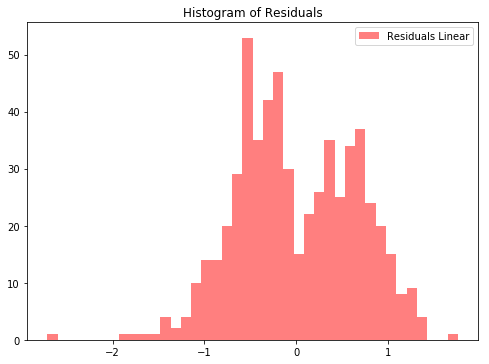

In [78]:
# 在训练集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_train - y_train_pred_lr, bins=40, label="Residuals Linear", color='red', alpha=.5)
ax.set_title("Histogram of Residuals")
ax.legend(loc='best')


### 4.尝试岭回归

### 4.1 训练模型

In [103]:
from sklearn.linear_model import RidgeCV

#设置超参数量级范围
alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas = alphas)

In [104]:
# 模型训练
ridge.fit(x_train, y_train)

RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=False)

In [105]:
# 预测
y_test_pred_rg = ridge.predict(x_test)
y_train_pred_rg = ridge.predict(x_train)
print (('the best alpha '), ridge.alpha_)

('the best alpha ', 1.0)


### 查看权重

In [106]:
ridge.coef_

array([[-0.46168155,  0.00818525, -0.12202999,  0.36173476, -0.0408129 ,
         0.00579712,  0.20122712, -0.0687529 ,  0.14390119, -0.10350943,
        -0.39027325, -0.13443184,  0.32533448,  0.09524976, -0.16768382,
        -0.07983706, -0.01524595, -0.19854557, -0.08680722, -0.026129  ,
        -0.08815302, -0.07817579, -0.09683106,  0.03498203,  0.12732254,
        -0.15803025, -0.05576127,  1.91440229,  1.5263651 , -1.91091303,
        -1.41702405]])

### 4.2参数优化 
### Ｑ1.请问助教，还有哪些参数调忧方法？

In [100]:
# 细化参数范围
ridge.set_params(alphas=np.array([.1, .5, .9, 1.3, 1.7]))
#ridge = RidgeCV(alphas=np.array([.1, .5, .9, 1.3, 1.7]))

print (('the best alpha '), ridge.alpha_)

('the best alpha ', 0.5)


In [108]:
# 提高精度
alphas_to_test = np.linspace(0.01, 0.9)
ridge.set_params(alphas=alphas_to_test, store_cv_values=True)
ridge.fit(x_train, y_train)

print (('the best alpha '), ridge.alpha_)

('the best alpha ', 0.40959183673469385)


In [114]:
# 再用新参数模型预测下
y_test_pred_rg = ridge.predict(x_test)
y_train_pred_rg = ridge.predict(x_train)
print (('the best alpha '), ridge.alpha_)

('the best alpha ', 0.40959183673469385)


In [109]:
ridge.cv_values_.shape

(584, 1, 50)

### 可视化交叉验证过程

### Ｑ2.请问助教，这里怎么修改？

IndexError: index 22 is out of bounds for axis 0 with size 1

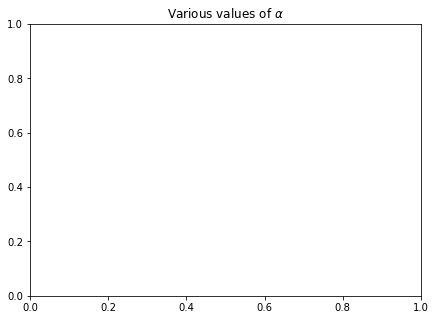

In [113]:
# 找到最小值
min_idx = ridge.cv_values_.mean(axis=0).argmin()
alphas_to_test[min_idx]

f, ax = plt.subplots(figsize=(7, 5))
ax.set_title(r'Various values of $\alpha$')

tmp = ridge.cv_values_.mean(axis=0)[min_idx]
xy = (alphas_to_test[min_idx], tmp)
xytext = (xy[0] + .01, xy[1] + .1)

ax.annotate(r'Chosen $\alpha$', xy = xy, xytext=xytext,
           arrowprops=dict(facecolor='black', shrink=0, width=0))
ax.plot(alphas_to_test, ridge.cv_values_.mean(axis=0))

###  模型评价

### R2性能评价

In [115]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print (('the r2 score of RidgeCV on test is '), r2_score(y_test, y_test_pred_rg))
print (('the r2 score of RidgeCV on train is '), r2_score(y_train, y_train_pred_rg))

('the r2 score of RidgeCV on test is ', 0.52075123619346575)
('the r2 score of RidgeCV on train is ', 0.57220744882136954)


### cross_val_score　评价

In [116]:
from sklearn.model_selection import cross_val_score

print cross_val_score(ridge, x_train, y_train, cv=4, n_jobs=2, pre_dispatch='2*n_jobs')

[ 0.49671764  0.55248849  0.43834474  0.54339071]


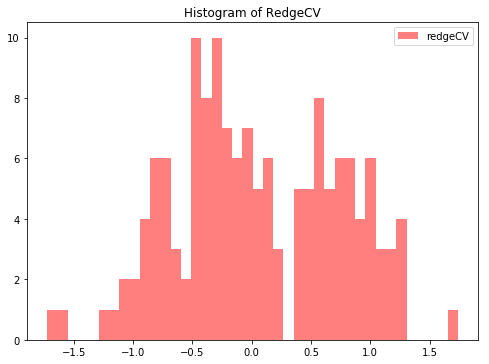

In [117]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_rg, bins=40, label="redgeCV", color='red', alpha=.5)
ax.set_title("Histogram of RedgeCV")
ax.legend(loc='best')

## Q3. 请问助教残差分布说明了什么问题？？

## 5. Lasso 模型

In [91]:
from sklearn.linear_model import LassoCV
#设置超参数范围
alphas = [0.01, 0.1, 1, 10, 100, 1000, 10000]
lasso = LassoCV(alphas=alphas)


In [92]:
lasso.fit(x_train, y_train)

/home/wyb/anaconda2/envs/python3/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LassoCV(alphas=[0.01, 0.1, 1, 10, 100, 1000, 10000], copy_X=True, cv=None,
    eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [124]:
y_train_pred_lso = lasso.predict(x_train)
y_test_pred_lso = lasso.predict(x_test)
print (('the best alpha '), lasso.alpha_)

('the best alpha ', 0.01)


## 超参数调优

In [120]:
alphas_to_test_laso = np.linspace(0.001, 0.9)
lasso.set_params(alphas=alphas_to_test)
# rcv = lasso(alphas=alphas_to_test, store_cv_values=True)
lasso.fit(x_train, y_train)

print (('the best alpha '), lasso.alpha_)

('the best alpha ', 0.01)


## Q4.请问怎么看下面这些权重有什么意义？

### 查看权重

In [129]:
lasso.coef_

array([-0.54223969,  0.        , -0.02316833,  0.21958966, -0.02480449,
       -0.        ,  0.04316023, -0.        ,  0.12185151,  0.        ,
       -0.11320373, -0.        ,  0.2432635 ,  0.12835253, -0.        ,
       -0.        ,  0.        , -0.        , -0.0626032 , -0.        ,
       -0.        , -0.        , -0.        ,  0.0284376 ,  0.01094155,
       -0.        ,  0.        ,  2.53963892,  0.        , -1.17384727, -0.        ])

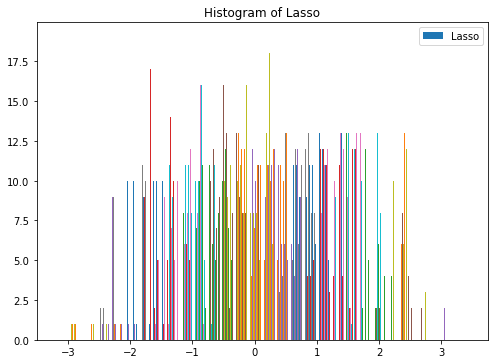

In [123]:
# 在测试集上观测预测残差分布
f, ax = plt.subplots(figsize=(7, 5))
f.tight_layout()
ax.hist(y_test - y_test_pred_lso, bins=30, label="Lasso")
ax.set_title("Histogram of Lasso")
ax.legend(loc='best')

### 模型评价

### R2评价

In [125]:
# 评估，使用r2_score评价模型在测试集和训练集上的性能
print (('the r2 score of Lasso on train is '), r2_score(y_train, y_train_pred_lso))
print (('the r2 score of Lasso on test is '), r2_score(y_test, y_test_pred_lso))

('the r2 score of Lasso on train is ', 0.51687406537545533)
('the r2 score of Lasso on test is ', 0.49731758721233366)


### cross_val_score　评价

In [126]:
from sklearn.model_selection import cross_val_score

print cross_val_score(lasso, x_train, y_train, cv=4, n_jobs=2, pre_dispatch='2*n_jobs')

[ 0.44114216  0.5150312   0.39660159  0.53475714]


## 对比OLS/岭回归和lasso模型评价，OLS得分更高些,是因为简单模型更好用么？